In [1]:
!python --version

Python 3.7.10


In [2]:
import random
import time
from typing import Counter
import warnings
import sys
import argparse
import shutil
import os.path as osp
import os
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.optim import SGD
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data.dataset import ConcatDataset
import numpy as np


sys.path.append("..")
sys.path.append("")
from common.modules.classifier import Classifier

# from dalib.adaptation.dann import DomainAdversarialLoss, ImageClassifier
from dalib.adaptation.degaa import ImageClassifier, GAA
import common.vision.datasets.openset as datasets
from common.vision.datasets.openset import default_open_set as open_set
import common.vision.models as models
from common.vision.transforms import ResizeImage
from common.utils.data import ForeverDataIterator
from common.utils.metric import accuracy, ConfusionMatrix
from common.utils.meter import AverageMeter, ProgressMeter
from common.utils.logger import CompleteLogger
from common.utils.analysis import collect_feature, tsne, a_distance
import network
from data_helper import setup_datasets
from torch.utils.tensorboard import SummaryWriter
# from torchsummary import summary

warnings.filterwarnings("ignore")

In [3]:
import torchvision
torchvision.__version__

'0.8.2'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print("Total GPUs Used:", torch.cuda.device_count())
i = 0
print("Hardwares Used: ")
while i < torch.cuda.device_count():
    print(i, ':', torch.cuda.get_device_name(i))
    i = i + 1
print("Device:", device)

Total GPUs Used: 3
Hardwares Used: 
0 : Tesla P100-PCIE-12GB
1 : Tesla P100-PCIE-12GB
2 : Tesla P100-PCIE-16GB
Device: cuda:0


In [4]:

import os
from torch.utils.data import DataLoader
from torch.utils.data.dataset import ConcatDataset
import torchvision.transforms as T
from common.vision.transforms import ResizeImage
import common.vision.datasets.openset as datasets
from common.vision.datasets.openset import default_open_set as open_set
from common.vision.datasets.Concatenate import ConcatenateDataset
from common.utils.data import ForeverDataIterator

def setup_datasets(args, concat=True, return_domain_idx=True):

    # if concat:
    ConcatD = ConcatenateDataset if return_domain_idx else ConcatDataset

    normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    train_transform = T.Compose([
            ResizeImage(256),
            T.CenterCrop(224),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            normalize,
        ])

    val_transform = T.Compose([ResizeImage(256), T.CenterCrop(224), T.ToTensor(), normalize])

    dataset = datasets.__dict__[args.dataset]
    source_dataset = open_set(dataset, source=True)
    target_dataset = open_set(dataset, source=False)
    if type(args.source) == str: # added this if to avoid repeatead modification of args.source
        args.source = args.source.split(",")
        args.target = args.target.split(",")
        if args.dataset == "OfficeHome":
            args.root = os.path.join(args.root, "office-home")

    source_datasets = [
        source_dataset(root=args.root, task=source, download=False, transform=train_transform)
        for source in args.source
    ]
    num_classes = len(source_datasets[0].classes)

    target_datasets = [
        target_dataset(root=args.root, task=target, download=False, transform=train_transform)
        for target in args.target
    ]   

    if concat:
        train_source_dataset = ConcatD(source_datasets)
        train_target_dataset = ConcatD(target_datasets)
    else:
        train_source_dataset = source_datasets
        train_target_dataset = target_datasets

    # Getting Loaders
    if concat:
        train_source_loader = DataLoader(
            train_source_dataset,
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=args.workers,
            drop_last=True,
        )
        train_target_loader = DataLoader(
            train_target_dataset,
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=args.workers,
            drop_last=True,
        )
    else:
        train_source_loader = [(DataLoader(
            dataset,
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=args.workers,
            drop_last=True,
        ))
        for dataset in train_source_dataset]
        train_target_loader = [(DataLoader(
            dataset,
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=args.workers,
            drop_last=True,
        ))
        for dataset in train_target_dataset]
        

    # val_dataset = target_dataset(
    #     root=args.root, task=args.target, download=True, transform=val_transform
    # )
    val_dataset = ConcatD([
            target_dataset(root=args.root, task=target, download=False, transform=train_transform)
            for target in args.target
        ]) 

    val_loader = DataLoader(
        val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers
    )

    if args.dataset == "DomainNet":
        test_dataset = dataset(
            root=args.root,
            task=args.target,
            split="test",
            download=True,
            transform=val_transform,
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=args.batch_size,
            shuffle=False,
            num_workers=args.workers,
        )
    else:
        test_loader = val_loader

    # train_source_iter = ForeverDataIterator(train_source_loader)
    # train_target_iter = ForeverDataIterator(train_target_loader)
    return num_classes, train_source_loader, train_target_loader, val_loader, test_loader
    

In [5]:
import torchvision
import matplotlib.pyplot as plt

In [15]:
%matplotlib inline

In [30]:
%cd /data/rohit_lal/os-nsmt/

/data/rohit_lal/os-nsmt


In [31]:
args = argparse.Namespace(dataset='OfficeHome', arch='resnet50', batch_size=32, lr=0.002, lr_gamma=0.001, bottleneck_dim=256, feature_dim=256, lr_decay=0.75, momentum=0.9, wd=0.001, workers=0, epochs=1000, root='/data/rohit_lal/os-nsmt/data', source='Ar,Pr', target='Cl,Rw', proto_path='./protoruns/run7/prototypes.pth', centroid_path='./centroids/OfficeHome/ArPr_centroid.npy', proto_dim=512, bottleneck=256, layer='wn', classifier='bn', trade_off=1.0, iters_per_epoch=500, print_freq=100, log='degaa', seed=0, phase='train', threshold=0.8, per_class_eval=False, tensorboard=False, wandb=False, output_dir='./adapt/run1', trained_wt='weights/oda', net='resnet50')

In [33]:
num_classes, train_source_loader, train_target_loader, val_loader, test_loader = setup_datasets(args, concat=True)

In [34]:
num_classes

26

In [11]:
sample = next(iter(train_source_loader))

In [12]:
sample[0][0].shape

torch.Size([32, 3, 224, 224])

In [13]:
grid = torchvision.utils.make_grid(sample[0][0], normalize=True)
grid.shape

torch.Size([3, 906, 1810])

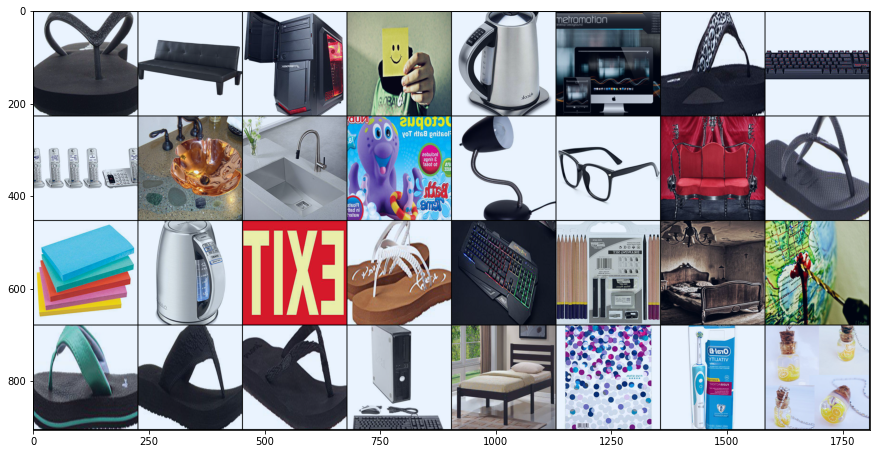

In [16]:
plt.figure(figsize=(15,10))
plt.imshow(grid.permute(1,2,0))

In [22]:
CLASSES = train_source_loader.dataset.datasets[0].classes
CLASSES

['Drill',
 'Exit_Sign',
 'Bottle',
 'Glasses',
 'Computer',
 'File_Cabinet',
 'Shelf',
 'Toys',
 'Sink',
 'Laptop',
 'Kettle',
 'Folder',
 'Keyboard',
 'Flipflops',
 'Pencil',
 'Bed',
 'Hammer',
 'ToothBrush',
 'Couch',
 'Bike',
 'Postit_Notes',
 'Mug',
 'Webcam',
 'Desk_Lamp',
 'Telephone',
 'unknown']

In [23]:
print([CLASSES[c] for c in sample[0][1]])

['Flipflops', 'Couch', 'Computer', 'Postit_Notes', 'Kettle', 'Computer', 'Flipflops', 'Keyboard', 'Telephone', 'Sink', 'Sink', 'Toys', 'Desk_Lamp', 'Glasses', 'Couch', 'Flipflops', 'Postit_Notes', 'Kettle', 'Exit_Sign', 'Flipflops', 'Keyboard', 'Pencil', 'Bed', 'Drill', 'Flipflops', 'Flipflops', 'Flipflops', 'Computer', 'Bed', 'Folder', 'ToothBrush', 'Bottle']


In [24]:
sample_t = next(iter(train_target_loader))

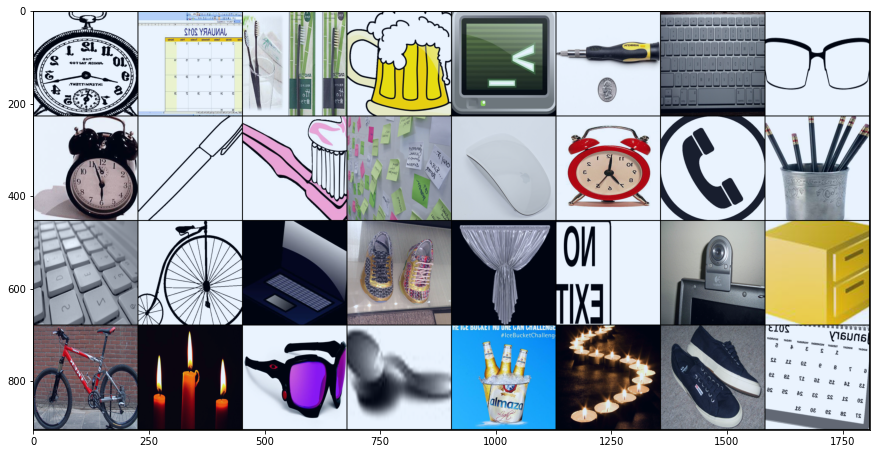

In [25]:
grid = torchvision.utils.make_grid(sample_t[0][0], normalize=True)

plt.figure(figsize=(15,10))
plt.imshow(grid.permute(1,2,0))

In [26]:
print([CLASSES[c] for c in sample_t[0][1]])

['unknown', 'unknown', 'ToothBrush', 'Mug', 'unknown', 'unknown', 'Keyboard', 'Glasses', 'unknown', 'unknown', 'ToothBrush', 'Postit_Notes', 'unknown', 'unknown', 'Telephone', 'Pencil', 'Keyboard', 'Bike', 'Laptop', 'unknown', 'unknown', 'Exit_Sign', 'Webcam', 'File_Cabinet', 'Bike', 'unknown', 'Glasses', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']


In [45]:
def attach_embd(prototypes, feats, dom_idx):
    dom_embd = prototypes[dom_idx] # accessing domain embedding according to domain index
                                    # shape: [bs, 512]
    x = torch.cat((feats, dom_embd), dim=1) # concat: ([bs, 2048], [bs, 512])
    return x

In [37]:
# num_classes = num_classes - 1
print(f"Num Classes: {num_classes}")
train_source_iter = ForeverDataIterator(train_source_loader)
train_target_iter = ForeverDataIterator(train_target_loader)

Num Classes: 26


In [40]:
# backbone = models.__dict__[args.arch](pretrained = True)
netF = network.ResBase(res_name=args.net).to(device)

# num_classes = args.num_classes  # train_source_dataset.num_classes
# num_classes = len(train_source_dataset.datasets[0].classes)
args.num_classes = num_classes

# classifier = ImageClassifier(backbone, num_classes = num_classes, bottleneck = args.bottleneck).to(device)
# summary(classifier, (3, 224, 224))

args.feature_dim = netF.in_features
netB = network.feat_bootleneck(
    type=args.classifier,
    feature_dim=args.feature_dim + args.proto_dim, # 2048 + 512
    bottleneck_dim=args.bottleneck, # 256
).to(device)
netC = network.feat_classifier(
    type=args.layer, class_num=args.num_classes, bottleneck_dim=args.bottleneck  # 256, #26
).to(device)

modelpathF = f'{args.trained_wt}/{args.dataset}/{"".join(args.source)}/source_F.pt'
netF.load_state_dict(torch.load(modelpathF))

modelpathB = f'{args.trained_wt}/{args.dataset}/{"".join(args.source)}/source_B.pt'
netB.load_state_dict(torch.load(modelpathB))

modelpathC = f'{args.trained_wt}/{args.dataset}/{"".join(args.source)}/source_C.pt'
netC.load_state_dict(torch.load(modelpathC))

gaa = GAA(
    input_dim=args.bottleneck,
    num_classes=num_classes,
    gnn_layers=6,
    num_heads=4,
).to(device)

classifier = [netF, netB, netC]

# optimizer = SGD(classifier.get_parameters(), args.lr, momentum = args.momentum, weight_decay = args.wd, nesterov = True)
param_group = []
learning_rate = args.lr
for k, v in netF.named_parameters():
    param_group += [{"params": v, "lr": learning_rate * 0.1}]
for k, v in netB.named_parameters():
    param_group += [{"params": v, "lr": learning_rate}]
for k, v in netC.named_parameters():
    param_group += [{"params": v, "lr": learning_rate}] 
for k, v in gaa.named_parameters():
    param_group += [{"params": v, "lr": learning_rate}]
optimizer = SGD(param_group, momentum = args.momentum, weight_decay = args.wd, nesterov = True)
lr_scheduler = LambdaLR(
    optimizer,
    lambda x: args.lr * (1 + args.lr_gamma * float(x)) ** (-args.lr_decay),
)


# summary(gaa, [(32, 1024),(32, 1024)])
centroids = np.load(args.centroid_path)
centroids = centroids[:num_classes-1]
# print(centroids.shape)

prototypes_file = os.path.join(args.proto_path)
prototypes = torch.load(prototypes_file)
# print(prototypes.keys())
prototypes = torch.stack(list(prototypes.values()), dim=0)  # shape: [4, 512]
prototypes = prototypes.to(device)

In [42]:
netF.train()
netB.train()
netC.train()
gaa.train()
clf = LocalOutlierFactor(n_neighbors=20,  contamination=0.1)
softmax = nn.Softmax(dim=1)

In [43]:
(x_s, label_s), ds_idx = next(train_source_iter)
(x_t, label_t), dt_idx = next(train_target_iter)

x_s = x_s.to(device)
label_s = label_s.to(device)
x_t = x_t.to(device)
label_t = label_t.to(device)

x = torch.cat((x_s, x_t), dim=0)  # x.shape [bs*2, 3, 224]
dom_idx = torch.cat((ds_idx, dt_idx), dim=0) # [bs*2]

In [46]:
feats = netF(x)
f = attach_embd(prototypes, feats, dom_idx) # [bs*2, 2048+512]
# f = torch.cat([feats, d_embd], dim=1)  # [bs*2, 2048+512]
f = netB(f)

# y_s, y_t = y.chunk(2, dim=0)
f_s, f_t = f.chunk(2, dim=0)

<AxesSubplot:xlabel='x_feat', ylabel='y_feat'>

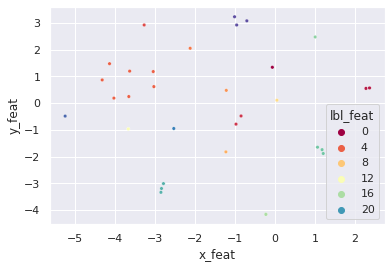

In [73]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

sns.set(style="darkgrid")

data_cen, data_feat = {}, {}
X_embedded = TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(f_s.cpu().detach().numpy())
data_cen['x_cent'], data_cen['y_cent'], data_cen['lbl_cent'] = X_embedded[:,0],X_embedded[:,1], np.arange(args.batch_size)
data_feat['x_feat'], data_feat['y_feat'], data_feat['lbl_feat'] = X_embedded[:,0],X_embedded[:,1], label_s.cpu().numpy()

data_feat=pd.DataFrame(data_feat)
data_cen=pd.DataFrame(data_cen)

sns.scatterplot(data=data_feat, x="x_feat", y="y_feat", legend=True, hue='lbl_feat', 
                    palette=sns.color_palette("Spectral", as_cmap=True) , alpha=1, s=12)
# sns.scatterplot(data=data_cen, x="x_cent", y="y_cent", hue='lbl_cent', legend=False, 
                    # marker='X', palette=sns.color_palette("Spectral", as_cmap=True))

<AxesSubplot:xlabel='x_feat', ylabel='y_feat'>

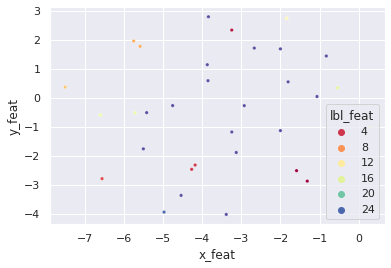

In [64]:
# for target data
data_cen, data_feat = {}, {}
X_embedded = TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(f_t.cpu().detach().numpy())
data_cen['x_cent'], data_cen['y_cent'], data_cen['lbl_cent'] = X_embedded[:,0],X_embedded[:,1], np.arange(args.batch_size)
data_feat['x_feat'], data_feat['y_feat'], data_feat['lbl_feat'] = X_embedded[:,0],X_embedded[:,1], label_t.cpu().numpy()

data_feat=pd.DataFrame(data_feat)
data_cen=pd.DataFrame(data_cen)

sns.scatterplot(data=data_feat, x="x_feat", y="y_feat", legend=True, hue='lbl_feat', 
                    palette=sns.color_palette("Spectral", as_cmap=True) , alpha=1, s=12)
# sns.scatterplot(data=data_cen, x="x_cent", y="y_cent", hue='lbl_cent', legend=False, 
                    # marker='X', palette=sns.color_palette("Spectral", as_cmap=True))

In [65]:
label_t

tensor([ 2,  9, 25, 25,  4, 25, 25, 25, 15, 25, 25,  9, 15, 25, 25, 25, 13,  2,
        25, 25, 10, 14, 25,  5, 16,  3,  4, 25, 24, 25, 25, 25],
       device='cuda:0')

In [66]:
label_tt = torch.empty_like(label_t) # shape [bs]
f_t_numpy = f_t.clone().cpu().detach().numpy()
y_pred = clf.fit_predict(f_t_numpy) # 2. store y_pred and calc unknown accuracy
index = np.where(y_pred == -1)  # for n outliers, shape [n, ..]
label_tt[index] = num_classes - 1 # 25 for all outliers !!
# [.., .., ..., 25, .., 25, ..,  25, ..]

index1 = np.where(y_pred == 1)  # for known classes [bs-n, ...]

In [70]:
label_ss = torch.empty_like(label_s) # shape [bs]
f_s_numpy = f_s.clone().cpu().detach().numpy()
y_pred = clf.fit_predict(f_s_numpy) # 2. store y_pred and calc unknown accuracy
index = np.where(y_pred == -1)  # for n outliers, shape [n, ..]
label_ss[index] = num_classes - 1 # 25 for all outliers !!
# [.., .., ..., 25, .., 25, ..,  25, ..]

label_s, y_pred

(tensor([ 2,  6,  9, 19,  1,  1,  3,  4,  2,  4, 18, 17, 22,  5,  4, 16, 23, 19,
         16,  4,  0, 21,  4,  4, 18, 23, 19,  7, 18,  4, 23, 12],
        device='cuda:0'),
 array([ 1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
         1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]))

In [75]:
f_t_numpy.shape

(32, 256)

In [80]:
from tqdm.notebook import tqdm

In [86]:
# concatenating all y_preds
F_T, Labels = [], []
for (x_t, label_t), dt_idx in tqdm(train_target_loader):
    x_t = x_t.to(device)
    # label_t = label_t.to(device)

    feats = netF(x_t)
    f = attach_embd(prototypes, feats, dt_idx)
    f_t = netB(f)

    F_T.append(f_t.clone().cpu().detach().numpy())
    Labels.append(label_t.cpu().numpy())


  0%|          | 0/272 [00:00<?, ?it/s]

In [87]:
all_feats = np.concatenate(F_T)
all_labels = np.concatenate(Labels)
all_feats.shape, all_labels.shape

((8704, 256), (8704,))

In [88]:
Y_PREDS = clf.fit_predict(all_feats)


In [92]:
sum(Y_PREDS==-1), sum(all_labels==25)

(871, 5225)

In [133]:
(np.intersect1d(np.where(Y_PREDS==-1), np.where(all_labels==25))).shape

(513,)

In [ ]:
# 513 out of total 5225 unknown where detected as outlier

In [94]:
def NearestNeighbor(known, centroids):
    dist = torch.cdist(known, centroids.to(torch.float32), p=2)
    knn = dist.topk(1, largest=False, dim=1) # dim=1 to access dominant in each of these inlier vectors
    return knn.indices

In [112]:
label_tt = np.empty_like(all_labels)
index = np.where(Y_PREDS==-1)
label_tt[index] = 25
index1 = np.where(Y_PREDS==1)

known = all_feats[index1]
# centroids = torch.from_numpy(centroids).to(device)
known_idx = NearestNeighbor(torch.from_numpy(known).to(device), centroids)

In [113]:
label_tt[index1] = known_idx.cpu().squeeze()

In [116]:
sum(label_tt == all_labels)

2820

In [137]:
sum(label_tt[index1] == all_labels[index1]), all_labels.shape

(2307, (8704,))

In [142]:
torch.index_select(sample_t[0][1], 0, ind) == torch.index_select(preds.argmax(dim=1), 0, ind)

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True])